In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fmin

In [2]:
data = np.loadtxt('full_ogtt.txt')

In [3]:
## Calibration du model.

    # 1) Visualisation des données

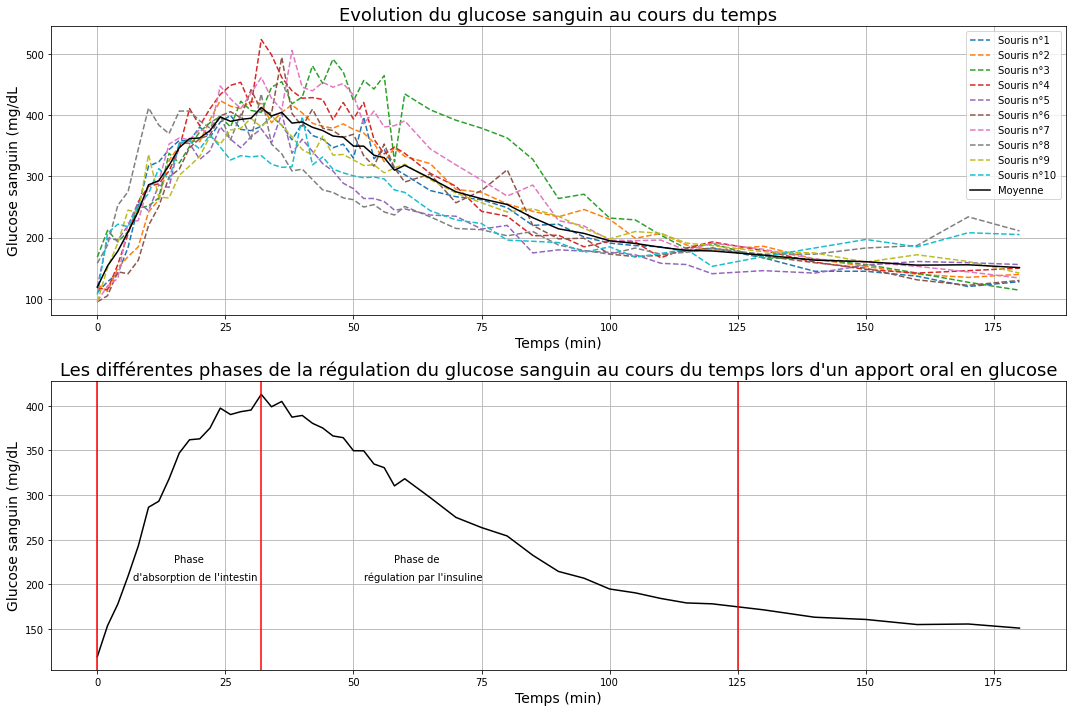

In [4]:
plt.rcParams["figure.figsize"] = [15, 10]

plt.subplot(211)
for k in range(1,np.shape(data)[1]-1):
    plt.plot(data[:,0],data[:,k],'--',label=f'Souris n°{k}')
plt.plot(data[:,0],data[:,-1],'k',label= 'Moyenne')
plt.legend()
plt.grid()
plt.title('Evolution du glucose sanguin au cours du temps',fontsize = 18)
plt.xlabel('Temps (min)',fontsize = 14)
plt.ylabel('Glucose sanguin (mg/dL',fontsize = 14)

plt.subplot(212)
plt.plot(data[:,0],data[:,-1],'k',label= 'Moyenne')
plt.axvline(x=data[np.where(data[:,-1]==max(data[:,-1]))[0][0],0],color='red')
plt.axvline(x=125,color='red')
plt.axvline(x=0,color='red')

plt.grid()
plt.title("Les différentes phases de la régulation du glucose sanguin au cours du temps lors d'un apport oral en glucose", fontsize = 18)
plt.xlabel('Temps (min)',fontsize = 14)
plt.ylabel('Glucose sanguin (mg/dL',fontsize = 14)

plt.text(15,225,'Phase')
plt.text(7,205,"d'absorption de l'intestin")

plt.text(58,225,'Phase de' )
plt.text(52,205,"régulation par l'insuline")

plt.tight_layout()
plt.show()

In [5]:
 # 2)

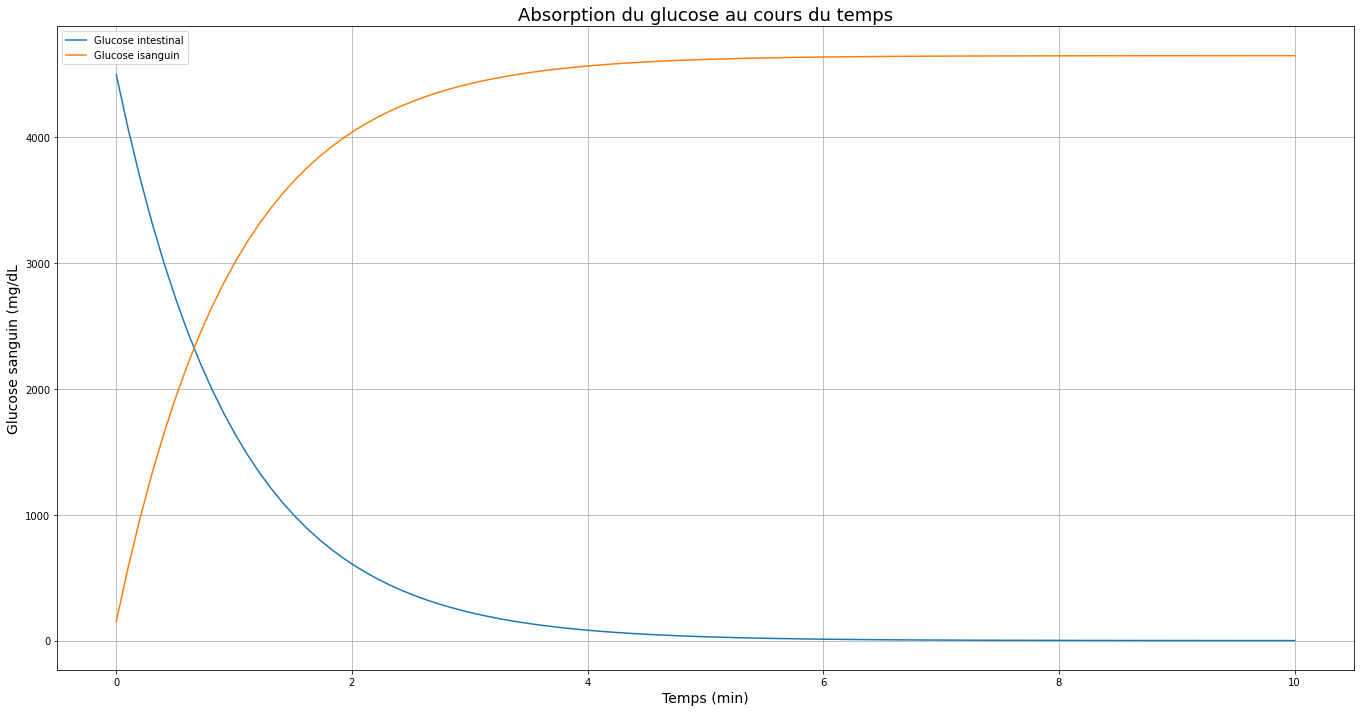

In [6]:
plt.rcParams["figure.figsize"] = [19, 10]

def Za(Z,t):
    a = 1
    res = [
        -Z[0]*a ,
        Z[0]*a
    ]
    return res

t = np.linspace(0,10,100)
y0 = [4500.0,150]

y = odeint(Za,y0,t)

plt.plot(t,y[:,0],label = "Glucose intestinal")
plt.plot(t,y[:,1],label = "Glucose isanguin")

plt.legend()
plt.grid()
plt.title('Absorption du glucose au cours du temps',fontsize = 18)
plt.xlabel('Temps (min)',fontsize = 14)
plt.ylabel('Glucose sanguin (mg/dL',fontsize = 14)

plt.tight_layout()

plt.show()

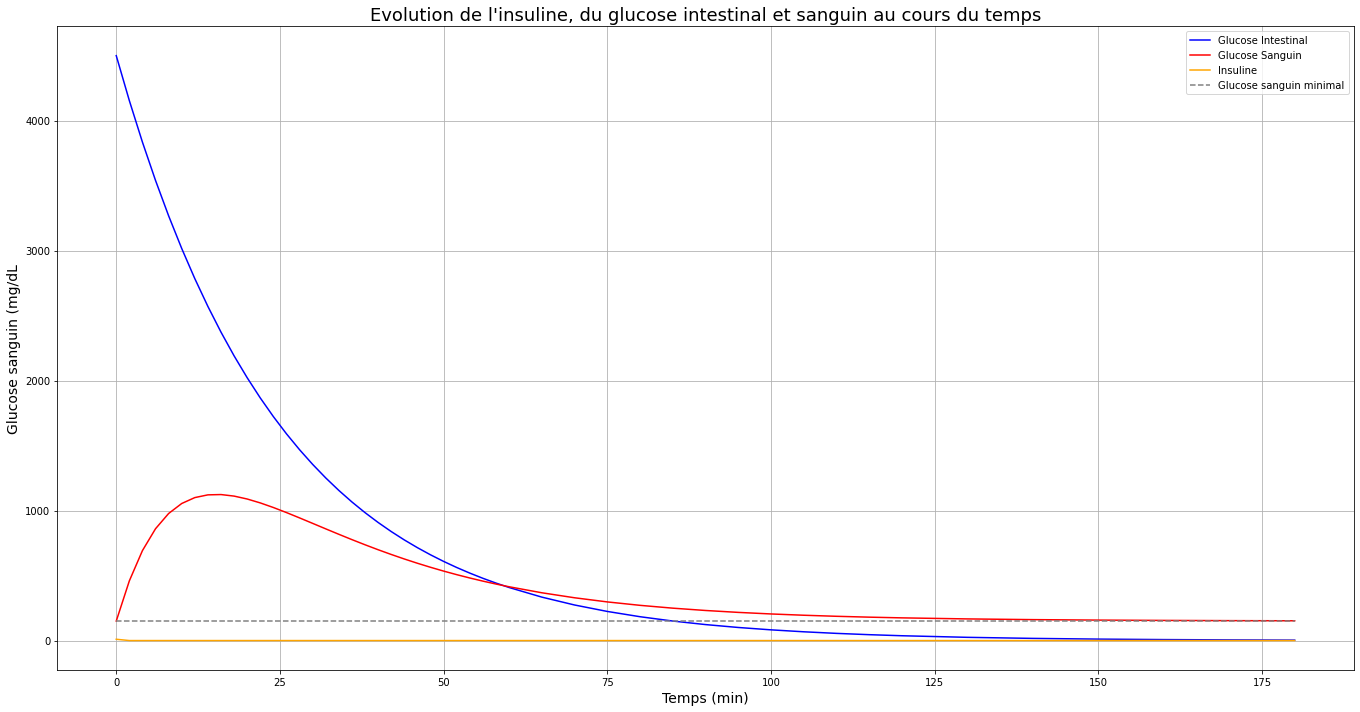

In [7]:
 #3) #4)
plt.rcParams["figure.figsize"] = [19, 10]

def Za(Z,t,a,b,c,s,r,m):
    
    Gi, Gs, I = Z

    Gs_seuil = 0.5
    Gs_base = 150

    res = [
        -Gi*a ,        
        c*max(Gs_seuil-Gs, 0)/(Gs_seuil-Gs) + Gi*a - (s*I*Gs + b*max(0, Gs-Gs_base)),
        r*Gs - m*I
    ]
    return res
# Il y a 6 paramètres libre : a, b, c, s, r, m

t = data[:,0]
G0 = 4500
y0 = [G0,150,10]

arg = (0.04, 0.1, 1, 0.01, 1e-4, 4)

y = odeint(Za,y0,t,args=arg)

plt.plot(t,y[:,0],color='blue',label ='Glucose Intestinal')
plt.plot(t,y[:,1],color='red',label ='Glucose Sanguin')
plt.plot(t,y[:,2],color='orange',label ='Insuline')
plt.plot(t,np.ones(len(t),)*150,color='gray',linestyle='--',label = 'Glucose sanguin minimal')
plt.legend()
plt.grid()
plt.title("Evolution de l'insuline, du glucose intestinal et sanguin au cours du temps",fontsize = 18)
plt.xlabel('Temps (min)',fontsize = 14)
plt.ylabel('Glucose sanguin (mg/dL',fontsize = 14)

plt.tight_layout()

plt.show()

In [8]:
# 6)
def sse(param) :

    a,b,c,s,r,m = param
    y0 = [G0,Gs_ini,I_ini]    
    y = odeint(Za,y0,data[:,0], args = (a,b,c,s,r,m))

    return np.sum((y[:,1]-data[:,-1])**2) + (a<0)*1e8 + (b<0)*1e8 + (c<0)*1e8 + (s<0)*1e8 +(r<0)*1e8 +(m<0)*1e8


G0 = 4500
Gs_ini, I_ini = 100, 10


minimum = fmin(sse, [ 0.04, 0.1, 1, 0.01, 1e-4, 4],maxiter=2500)
print(minimum)

c:\Users\basti\AppData\Local\Programs\Python\Python38-32\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimization terminated successfully.
         Current function value: 42284.965442
         Iterations: 620
         Function evaluations: 1005
[1.53011573e-02 1.79872120e-01 1.97570562e+00 1.82796012e-02
 1.62473335e-13 1.04384279e-01]


In [9]:
# Le paramètre 'c' n'influence pas les équations donc on le fixe à 1.
def Za(Z,t,a,b,s,r,m):
    
    Gi, Gs, I = Z
    
    Gs_base = 150

    res = [
        -Gi*a ,        
        Gi*a - (s*I*Gs + b*max(0, Gs-Gs_base)),
        r*Gs - m*I
    ]
    return res

def sse(param) :

    a,b,s,r,m = param
    y0 = [G0,Gs_ini,I_ini]    
    y = odeint(Za,y0,data[:,0], args = (a,b,s,r,m))

    return np.sum((y[:,1]-data[:,-1])**2) + (a<0)*1e8 + (b<0)*1e8 + (s<0)*1e8 +(r<0)*1e8 +(m<0)*1e8


G0 = 4500
Gs_ini, I_ini = 100, 10


minimum = fmin(sse, [ 0.04, 0.1, 0.01, 1e-3, 0.01],maxiter=2500)
# paramètres optimisés en faisant des tes d'ordre de grandeur
print(minimum)

Optimization terminated successfully.
         Current function value: 2411.270350
         Iterations: 683
         Function evaluations: 1104
[0.00523835 0.00095422 0.00286925 0.00108924 0.0082625 ]


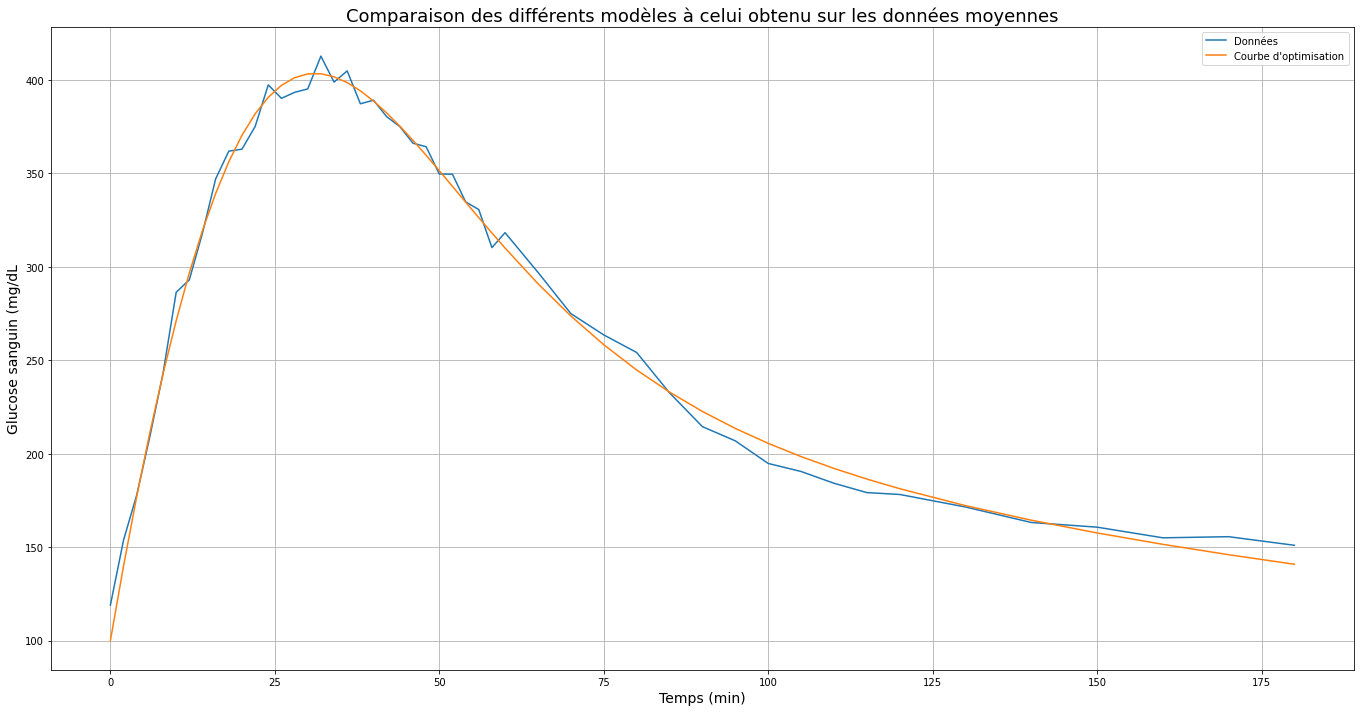

In [10]:
# test
plt.rcParams["figure.figsize"] = [19, 10]

def Za1(Z,t):    
    Gi, Gs, I = Z
    
    Gs_base = 150

    res = [
        -Gi*a ,        
        Gi*a - (s*I*Gs + b*max(0, Gs-Gs_base)),
        r*Gs - m*I
    ]
    return res

a,b,s,r,m = list(minimum)
y0 = [4500,Gs_ini,I_ini]
y = odeint(Za1,y0,data[:,0])

plt.plot(data[:,0],data[:,-1], label = "Données")
plt.plot(data[:,0],y[:,1], label = "Courbe d'optimisation")
plt.legend()
plt.grid()
plt.title('Comparaison des différents modèles à celui obtenu sur les données moyennes',fontsize = 18)
plt.xlabel('Temps (min)',fontsize = 14)
plt.ylabel('Glucose sanguin (mg/dL',fontsize = 14)

plt.tight_layout()

plt.show()

In [11]:
# Paramètres optimaux de chaque souris
Minimum = []
for k in range(1,len(data[0])-1) :

    def sse(param) :
        a,b,s,r,m = param
        y0 = [G0,Gs_ini,I_ini]    
        y = odeint(Za,y0,data[:,0], args = (a,b,s,r,m))

        return np.sum((y[:,1]-data[:,k])**2) + (a<0)*1e8 + (b<0)*1e8 + (s<0)*1e8 +(r<0)*1e8 +(m<0)*1e8

    Minimum.append(fmin(sse, [ 0.04, 0.1, 0.01, 0.001, 0.01],maxiter=2500))

Optimization terminated successfully.
         Current function value: 13233.937977
         Iterations: 689
         Function evaluations: 1121
Optimization terminated successfully.
         Current function value: 39290.229143
         Iterations: 330
         Function evaluations: 556
Optimization terminated successfully.
         Current function value: 43035.674734
         Iterations: 461
         Function evaluations: 770
Optimization terminated successfully.
         Current function value: 18673.388526
         Iterations: 432
         Function evaluations: 720
Optimization terminated successfully.
         Current function value: 19691.630731
         Iterations: 825
         Function evaluations: 1331
Optimization terminated successfully.
         Current function value: 181315.330380
         Iterations: 344
         Function evaluations: 585
Optimization terminated successfully.
         Current function value: 55344.062866
         Iterations: 495
         Function evalua

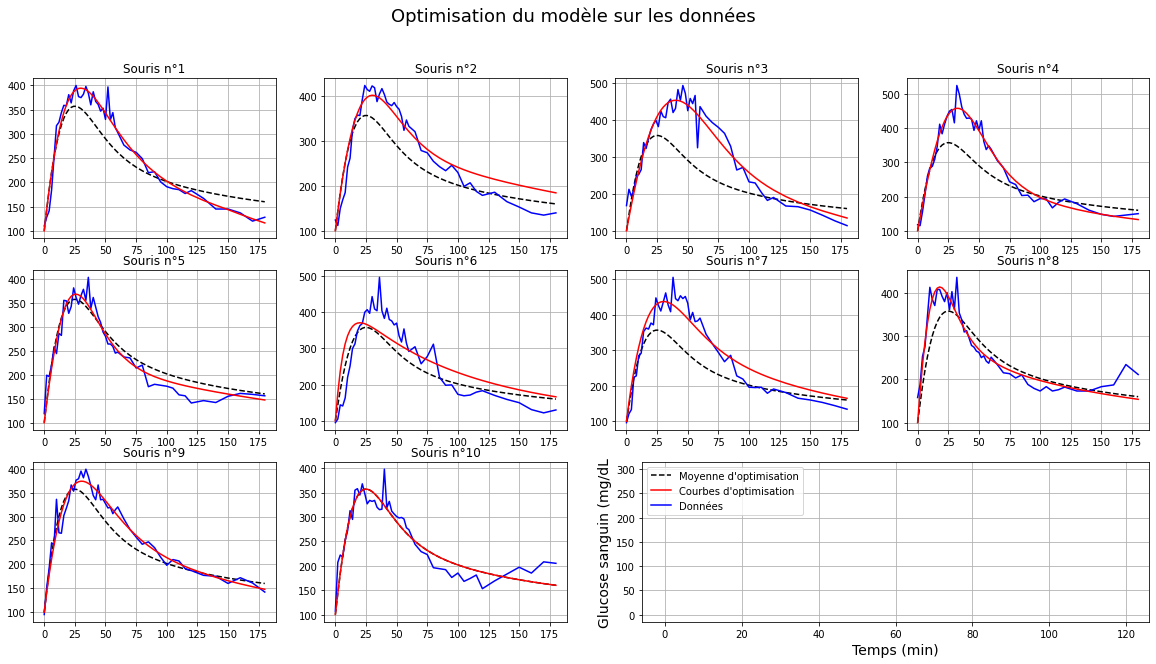

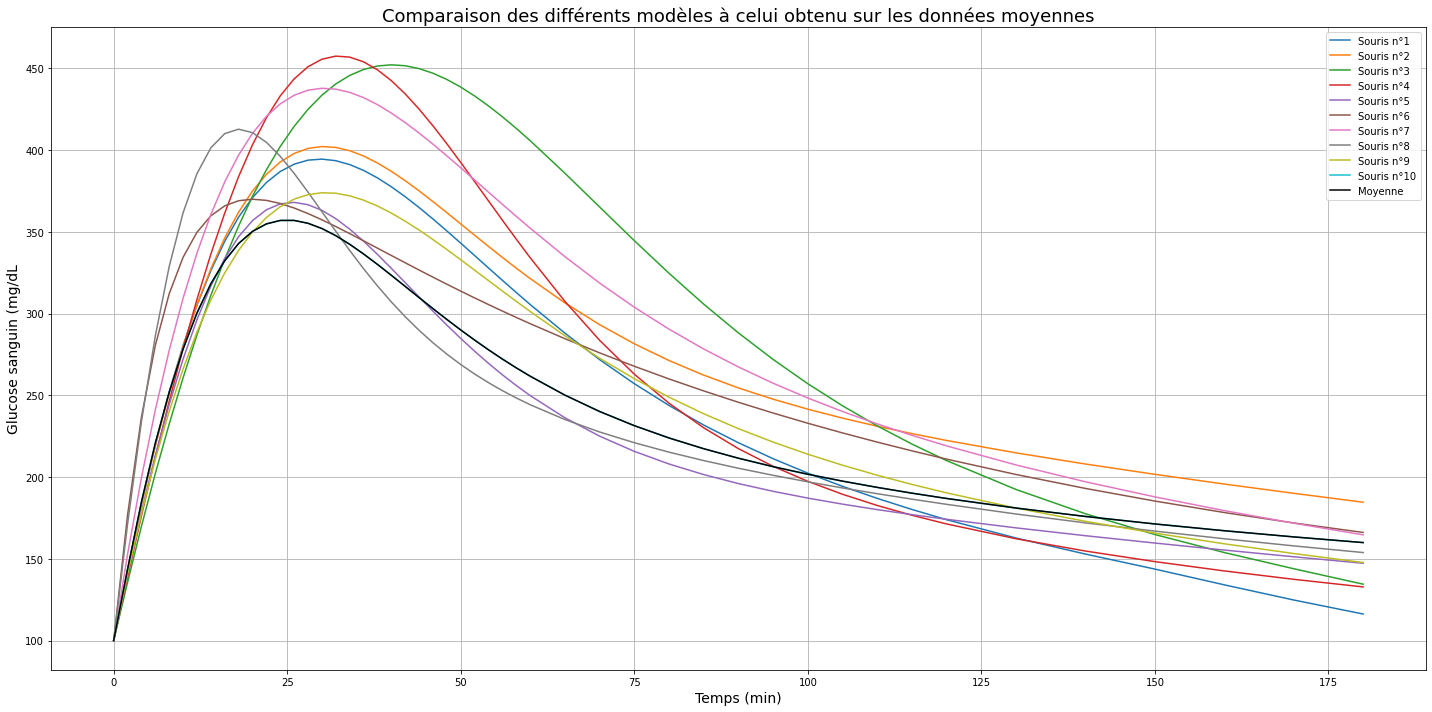

In [12]:
# Affichage des courbes de chaque souris

def Za1(Z,t):    
    Gi, Gs, I = Z

    Gs_base = 150

    res = [
        -Gi*a ,        
        Gi*a - (s*I*Gs + b*max(0, Gs-Gs_base)),
        r*Gs - m*I
    ]
    return res

plt.rcParams["figure.figsize"] = [20, 10]

plt.figure()
plt.suptitle('Optimisation du modèle sur les données',fontsize = 18)
for k in range(len(Minimum)) :

    plt.subplot(3,4,k+1)
    a,b,s,r,m = list(Minimum[-1])
    y = odeint(Za1,y0,data[:,0])    
    plt.plot(data[:,0],y[:,1], linestyle='--', color = 'k')
    
    a,b,s,r,m = list(Minimum[k])
    y0 = [4500,Gs_ini,I_ini]
    y = odeint(Za1,y0,data[:,0])

    plt.plot(data[:,0],data[:,k+1], color = 'b')
    plt.plot(data[:,0],y[:,1],  color = 'r')
    plt.grid()
    plt.title(f"Souris n°{k+1}")

plt.subplot(3,2,6)
plt.plot(0,0,color='k',linestyle='--',label = "Moyenne d'optimisation")
plt.plot(0,0,color='r',label = "Courbes d'optimisation")
plt.plot(0,0,color='b',label = "Données")
plt.plot(120,300)
plt.grid()
plt.legend()
plt.xlabel('Temps (min)',fontsize = 14)
plt.ylabel('Glucose sanguin (mg/dL',fontsize = 14)

plt.figure()
for k in range(len(Minimum)) :

    a,b,s,r,m = list(Minimum[k])
    y0 = [4500,Gs_ini,I_ini]
    y = odeint(Za1,y0,data[:,0])    
    plt.plot(data[:,0],y[:,1], label = f'Souris n°{k+1}')
    
a,b,s,r,m = list(Minimum[-1])
y = odeint(Za1,y0,data[:,0])    
plt.plot(data[:,0],y[:,1],'k', label = 'Moyenne')
plt.legend()
plt.grid()
plt.title('Comparaison des différents modèles à celui obtenu sur les données moyennes',fontsize = 18)
plt.xlabel('Temps (min)',fontsize = 14)
plt.ylabel('Glucose sanguin (mg/dL',fontsize = 14)

plt.tight_layout()
plt.show()


In [13]:
# Optimisation totale
def sse_tot(param) :
    a,b,s,r,m = param
    y0 = [G0,Gs_ini,I_ini]    
    y = odeint(Za,y0,data[:,0], args = (a,b,s,r,m))
    tot = 0
    for k in range(1,len(data[0])) :
        tot += np.sum((y[:,1]-data[:,k])**2)
    tot += (a<0)*1e8 + (b<0)*1e8 + (s<0)*1e8 +(r<0)*1e8 +(m<0)*1e8

    return tot

minimum_tot = fmin(sse_tot, [ 0.04, 0.1, 0.01, 1e-3, 0.01])
print(minimum_tot)

[1.13646725e-02 1.24825697e-10 1.21957770e-02 5.13074505e-04
 2.54020057e-02]


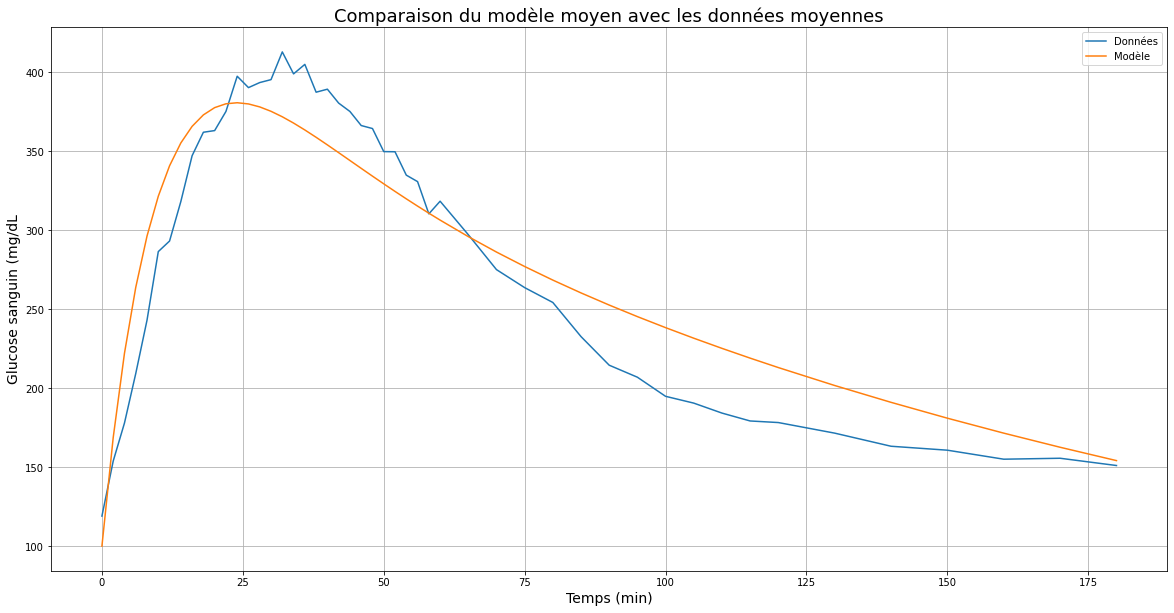

In [14]:
# test 2
def Za1(Z,t):    
    Gi, Gs, I = Z
    
    Gs_base = 150

    res = [
        -Gi*a ,        
        Gi*a - (s*I*Gs + b*max(0, Gs-Gs_base)),
        r*Gs - m*I
    ]
    return res

a,b,s,r,m = list(minimum_tot)
y0 = [4500,Gs_ini,I_ini]
y = odeint(Za1,y0,data[:,0])

plt.plot(data[:,0],data[:,-1],label = "Données")
plt.plot(data[:,0],y[:,1], label = "Modèle")

plt.legend()
plt.grid()
plt.title("Comparaison du modèle moyen avec les données moyennes",fontsize = 18)
plt.xlabel('Temps (min)',fontsize = 14)
plt.ylabel('Glucose sanguin (mg/dL',fontsize = 14)

plt.show()